### ETAPA 1: Preparação dos Dados para Recomendação

In [ ]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import json
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
from collections import defaultdict


In [2]:
try:
    notebook_path = os.path.dirname(__file__) # Para scripts .py
except NameError:
    notebook_path = os.getcwd() # Para notebooks .ipynb

# Sobe na árvore de diretórios até encontrar a pasta raiz do projeto ('Challenge_ClickBus')
# Ele faz isso procurando por um arquivo/pasta que sempre existe na raiz, como o '.gitignore'
project_root = notebook_path
while not os.path.exists(os.path.join(project_root, '.gitignore')):
    project_root = os.path.dirname(project_root)
    if project_root == os.path.dirname(project_root): # Evita loop infinito
        raise FileNotFoundError("Não foi possível encontrar a raiz do projeto. Verifique se o arquivo '.gitignore' existe.")


# Constrói o caminho para a pasta de dados a partir da raiz
CSV = os.path.join(project_root,'Desafios', 'data', 'csv') + '/'

print(f"Pasta de dados encontrada em: {CSV}")

Pasta de dados encontrada em: c:\Users\pedro\Documents\Estudos\FIAP\Challenges\ClickBus\Desafios\data\csv/


In [3]:
caminho_vendas = f'{CSV}vendas.csv'
df_vendas = pd.read_csv(caminho_vendas, sep=',', encoding='utf-8')

# 1. Carregar as previsões do Desafio 2
# (Ajuste o nome do arquivo e o caminho se necessário)
try:
    caminho_previsoes = f'{CSV}previsoes_finais_desafio2.csv'
    df_previsoes = pd.read_csv(caminho_previsoes)
    print(f"Arquivo de previsões '{caminho_previsoes}' carregado com sucesso.")

    # 2. Definir o limite de probabilidade
    PROB_LIMITE = 83 # 85%

    # 3. Filtrar os clientes com alta probabilidade de compra
    clientes_alta_prob = df_previsoes[df_previsoes['probabilidade_recompra_30d'] >= PROB_LIMITE]
    
    # 4. Verificar a quantidade de clientes selecionados
    print(f"\nTemos {len(clientes_alta_prob)} clientes com probabilidade de compra >= {PROB_LIMITE}%.")

    # Se tivermos mais de 50k clientes, podemos manter apenas os top 50k
    if len(clientes_alta_prob) > 50000:
        print("A base de clientes com alta probabilidade é maior que 50k.")
        print("Mantendo os Top 50k clientes com maior probabilidade.")
        clientes_alta_prob = clientes_alta_prob.nlargest(50000, 'probabilidade_recompra_30d')

    # 5. Filtrar o DataFrame de vendas para manter apenas as transações desses clientes
    lista_clientes_selecionados = clientes_alta_prob['fk_contact'].unique()
    df_vendas_filtrado = df_vendas[df_vendas['fk_contact'].isin(lista_clientes_selecionados)].copy()

    print(f"\nO DataFrame de vendas foi filtrado.")
    print(f"Número original de vendas: {len(df_vendas)}")
    print(f"Número de vendas após o filtro: {len(df_vendas_filtrado)}")
    
    # Substituir o df_vendas original pelo filtrado para o restante do notebook
    df_vendas = df_vendas_filtrado

except FileNotFoundError:
    print(f"ERRO: O arquivo de previsões 'previsoes_desafio2.csv' não foi encontrado.")
    print("O notebook continuará a execução com todos os clientes, mas o ideal é aplicar o filtro.")

Arquivo de previsões 'c:\Users\pedro\Documents\Estudos\FIAP\Challenges\ClickBus\Desafios\data\csv/previsoes_finais_desafio2.csv' carregado com sucesso.

Temos 50225 clientes com probabilidade de compra >= 83%.
A base de clientes com alta probabilidade é maior que 50k.
Mantendo os Top 50k clientes com maior probabilidade.

O DataFrame de vendas foi filtrado.
Número original de vendas: 1133310
Número de vendas após o filtro: 337135


In [4]:
# ETAPA 1: Preparação dos Dados para Recomendação

# Garante que a coluna de data de compra está no formato correto
df_vendas['date_purchase'] = pd.to_datetime(df_vendas['date_purchase'])

# Cria a coluna 'hora_da_compra' a partir de 'time_purchase'
df_vendas['hora_da_compra'] = pd.to_datetime(df_vendas['time_purchase'], format='%H:%M:%S').dt.hour

# Cria a coluna 'dia_da_semana' a partir de 'date_purchase'
dias_semana_map = {
    'Monday': '2-Segunda', 'Tuesday': '3-Terça', 'Wednesday': '4-Quarta',
    'Thursday': '5-Quinta', 'Friday': '6-Sexta', 'Saturday': '7-Sábado', 'Sunday': '1-Domingo'
}
df_vendas['dia_da_semana'] = df_vendas['date_purchase'].dt.day_name().map(dias_semana_map)

print("Colunas 'hora_da_compra' e 'dia_da_semana' criadas com sucesso.")
# Removido o .head() para um output mais limpo

# 1. Criar a feature 'rota'
df_vendas['rota'] = df_vendas['place_origin_departure'] + ' -> ' + df_vendas['place_destination_departure']

# 2. Ordenar as transações por cliente e data
df_vendas['datetime'] = pd.to_datetime(df_vendas['date_purchase'].astype(str) + ' ' + df_vendas['time_purchase'])
df_vendas = df_vendas.sort_values(by=['fk_contact', 'datetime'])

# 3. CRIAR A VARIÁVEL-ALVO (y)
df_vendas['proxima_rota'] = df_vendas.groupby('fk_contact')['rota'].shift(-1)

# 4. Criar o DataFrame de treino
df_recomendacao = df_vendas.dropna(subset=['proxima_rota']).copy()

print("\nDataFrame para o sistema de recomendação criado com sucesso.")
print(f"Temos {len(df_recomendacao)} exemplos de treino (apenas de clientes de alta probabilidade).")

Colunas 'hora_da_compra' e 'dia_da_semana' criadas com sucesso.

DataFrame para o sistema de recomendação criado com sucesso.
Temos 287135 exemplos de treino (apenas de clientes de alta probabilidade).


In [5]:
# 1. DIVIDIR OS DADOS EM TREINO E TESTE
train_data, test_data = train_test_split(df_recomendacao, test_size=0.2, random_state=42)

print(f"Dados de treino: {len(train_data)} interações")
print(f"Dados de teste: {len(test_data)} interações")

# 2. CONSTRUIR O MODELO DE BASELINE
most_frequent_routes = train_data.groupby('fk_contact')['rota'].agg(lambda x: x.value_counts().index[0])
baseline_model = most_frequent_routes.to_dict()

# 3. AVALIAR O BASELINE NO CONJUNTO DE TESTE
test_data['recomendacao_baseline'] = test_data['fk_contact'].map(baseline_model)
acertos = test_data[test_data['proxima_rota'] == test_data['recomendacao_baseline']].shape[0]
total_testes = len(test_data)
acuracia_baseline = (acertos / total_testes) * 100

print(f"\n--- Performance do Modelo de Baseline ---")
print(f"O modelo de 'rota mais frequente' acertou a próxima compra em {acuracia_baseline:.2f}% das vezes.")


Dados de treino: 229708 interações
Dados de teste: 57427 interações

--- Performance do Modelo de Baseline ---
O modelo de 'rota mais frequente' acertou a próxima compra em 41.75% das vezes.


In [6]:
# ETAPA 6: Modelo Sequencial (Cadeias de Markov)

print("Iniciando o treinamento do modelo de Cadeias de Markov...")

# 1. Construir a Matriz de Transição
# Para cada rota 'origem', contamos a frequência de cada 'próxima_rota'
# Isso nos dará a probabilidade de transição P(Próxima Rota | Rota Atual)
transition_counts = train_data.groupby('rota')['proxima_rota'].value_counts()
transition_totals = train_data.groupby('rota')['proxima_rota'].count()
transition_probabilities = transition_counts.div(transition_totals, level='rota')

# 2. Criar o modelo (um dicionário com a transição mais provável)
# Para cada rota, pegamos a 'próxima_rota' com a maior probabilidade
markov_model = {}
# Usamos .loc para pegar o primeiro índice (a rota mais provável) para cada grupo
idx = transition_probabilities.groupby('rota').idxmax()
# Extraímos os valores de 'proxima_rota'
most_likely_transitions = idx.apply(lambda x: x[1])
markov_model = most_likely_transitions.to_dict()

print("Modelo treinado com sucesso.")

# 3. Gerar recomendações para o conjunto de teste
print("\nGerando recomendações para o conjunto de teste...")

# A recomendação é simplesmente a transição mais provável a partir da rota atual do cliente
# Usamos .get() para o caso de uma rota no teste não ter sido vista no treino
test_data['recomendacao_markov'] = test_data['rota'].map(markov_model)
print("Recomendações geradas.")

# 4. Avaliar a acurácia do modelo
test_data_markov_eval = test_data.dropna(subset=['recomendacao_markov'])
acertos_markov = test_data_markov_eval[test_data_markov_eval['proxima_rota'] == test_data_markov_eval['recomendacao_markov']].shape[0]
total_testes_markov = len(test_data_markov_eval)
acuracia_markov = (acertos_markov / total_testes_markov) * 100

print(f"\n--- Performance Final dos Modelos ---")
print(f"Acurácia do Baseline (Rota Mais Frequente): {acuracia_baseline:.2f}%")
print(f"Acurácia do SVD: 17.39%")
print(f"Acurácia do Cadeias de Markov: {acuracia_markov:.2f}%")

if acuracia_markov > acuracia_baseline:
    print("\nAVALIAÇÃO: SUCESSO! O modelo de Cadeias de Markov é superior ao baseline.")
else:
    print("\nAVALIAIAÇÃO: O modelo de Cadeias de Markov não superou o baseline.")

Iniciando o treinamento do modelo de Cadeias de Markov...
Modelo treinado com sucesso.

Gerando recomendações para o conjunto de teste...
Recomendações geradas.

--- Performance Final dos Modelos ---
Acurácia do Baseline (Rota Mais Frequente): 41.75%
Acurácia do SVD: 17.39%
Acurácia do Cadeias de Markov: 37.21%

AVALIAIAÇÃO: O modelo de Cadeias de Markov não superou o baseline.


In [7]:
# ETAPA 7: Modelo Híbrido (Markov com Fallback para o Baseline)

print("Iniciando a criação do modelo híbrido...")

# 1. Gerar recomendações com o modelo de Markov
# (Já fizemos isso na etapa anterior, a coluna 'recomendacao_markov' já existe)

# 2. Preencher os valores nulos da recomendação de Markov com a recomendação do Baseline
# Usamos o .fillna() para aplicar a lógica de fallback
test_data['recomendacao_hibrida'] = test_data['recomendacao_markov'].fillna(test_data['recomendacao_baseline'])

print("Recomendações do modelo híbrido geradas com sucesso.")

# 3. Avaliar a acurácia do modelo Híbrido
# Removemos os casos onde nem o Markov nem o Baseline conseguiram gerar uma recomendação
test_data_hibrido_eval = test_data.dropna(subset=['recomendacao_hibrida'])

acertos_hibrido = test_data_hibrido_eval[test_data_hibrido_eval['proxima_rota'] == test_data_hibrido_eval['recomendacao_hibrida']].shape[0]
total_testes_hibrido = len(test_data_hibrido_eval)
acuracia_hibrido = (acertos_hibrido / total_testes_hibrido) * 100

print(f"\n--- Performance Final dos Modelos ---")
print(f"Acurácia do Baseline (Rota Mais Frequente): {acuracia_baseline:.2f}%")
print(f"Acurácia do SVD: 17.39%")
print(f"Acurácia do Cadeias de Markov: {acuracia_markov:.2f}%")
print(f"Acurácia do Modelo Híbrido: {acuracia_hibrido:.2f}%")

if acuracia_hibrido > acuracia_baseline:
    print("\nAVALIAÇÃO: SUCESSO! O modelo Híbrido superou o baseline e é o nosso melhor modelo!")
else:
    print("\nAVALIAÇÃO: O modelo Híbrido não superou o baseline. O comportamento de lealdade à rota ainda é a melhor estratégia.")


Iniciando a criação do modelo híbrido...
Recomendações do modelo híbrido geradas com sucesso.

--- Performance Final dos Modelos ---
Acurácia do Baseline (Rota Mais Frequente): 41.75%
Acurácia do SVD: 17.39%
Acurácia do Cadeias de Markov: 37.21%
Acurácia do Modelo Híbrido: 37.01%

AVALIAÇÃO: O modelo Híbrido não superou o baseline. O comportamento de lealdade à rota ainda é a melhor estratégia.


In [8]:
# --- MUDANÇA NA ETAPA 2: Divisão Temporal ---

# Encontra a data mais recente no nosso dataframe de recomendação
data_mais_recente = df_recomendacao['datetime'].max()
# Define a data de corte (ex: 30 dias antes da data mais recente)
data_corte = data_mais_recente - pd.Timedelta(days=60)

# O conjunto de treino são todos os dados ANTES da data de corte
train_data = df_recomendacao[df_recomendacao['datetime'] < data_corte]
# O conjunto de teste são todos os dados DEPOIS da data de corte
test_data = df_recomendacao[df_recomendacao['datetime'] >= data_corte].copy()

print(f"Dados divididos por tempo.")
print(f"Data de corte: {data_corte.date()}")
print(f"Período de Treino: {train_data['datetime'].min().date()} a {train_data['datetime'].max().date()}")
print(f"Período de Teste: {test_data['datetime'].min().date()} a {test_data['datetime'].max().date()}")
print(f"Dados de treino: {len(train_data)} interações")
print(f"Dados de teste: {len(test_data)} interações")

Dados divididos por tempo.
Data de corte: 2024-02-01
Período de Treino: 2021-01-01 a 2024-02-01
Período de Teste: 2024-02-01 a 2024-04-01
Dados de treino: 261866 interações
Dados de teste: 25269 interações


In [9]:
# ETAPA 3: Reavaliação do Baseline e Prova de Valor com Backtesting

print("Iniciando a reavaliação do modelo Baseline com a divisão temporal...")

# --- Parte 1: Treinar o modelo Baseline com os novos dados de treino ---
# O modelo agora aprende apenas com o histórico ANTES da data de corte
top_5_frequent_routes = train_data.groupby('fk_contact')['rota'].apply(lambda x: x.value_counts().head(5).index.tolist())
baseline_model_top5 = top_5_frequent_routes.to_dict()

# Mapeia as 5 principais recomendações para cada cliente no conjunto de teste
test_data.loc[:, 'recomendacao_top5'] = test_data['fk_contact'].map(baseline_model_top5)
# Garante que a coluna seja uma lista vazia para clientes sem histórico no treino, evitando erros
test_data.loc[:, 'recomendacao_top5'] = test_data['recomendacao_top5'].apply(lambda x: x if isinstance(x, list) else [])

# A recomendação principal (Top 1) é o primeiro item da lista
test_data.loc[:, 'recomendacao_top1'] = test_data['recomendacao_top5'].apply(lambda x: x[0] if x else None)

# --- Parte 2: Calcular as métricas de performance no conjunto de teste ---

# Acurácia@1: Verifica se a principal recomendação foi a rota comprada
acertos_top1 = (test_data['recomendacao_top1'] == test_data['proxima_rota']).sum()
acuracia_at_1 = (acertos_top1 / len(test_data)) * 100

# Recall@5: Verifica se a rota comprada estava entre as 5 recomendações
def check_hit_top5(row):
    return row['proxima_rota'] in row['recomendacao_top5']

hits_top5 = test_data.apply(check_hit_top5, axis=1).sum()
recall_at_5 = (hits_top5 / len(test_data)) * 100

print(f"\n--- Performance do Modelo (Avali-ação Temporal) ---")
print(f"Acurácia@1 (Acertar a 1ª recomendação): {acuracia_at_1:.2f}%")
print(f"Recall@5 (Acertar entre as 5 primeiras): {recall_at_5:.2f}%")

# --- Parte 3: Simulação de Impacto no Negócio (Prova de Valor) ---
# Aqui, medimos a "taxa de acerto" do modelo no universo de clientes do teste

clientes_unicos_no_teste = test_data['fk_contact'].nunique()

# Filtra o dataframe para incluir apenas as previsões corretas (hits)
acertos_df = test_data[test_data.apply(check_hit_top5, axis=1)]
clientes_impactados_pelo_modelo = acertos_df['fk_contact'].nunique()

taxa_de_acerto_clientes = (clientes_impactados_pelo_modelo / clientes_unicos_no_teste) * 100
vendas_adicionais_estimadas = (50000 * (recall_at_5 / 100))

print(f"\n\n--- Simulação de Impacto no Negócio (Backtesting) ---")
print(f"Clientes únicos no período de teste: {clientes_unicos_no_teste}")
print(f"O modelo gerou uma recomendação correta (dentro do Top 5) para {clientes_impactados_pelo_modelo} desses clientes.")
print(f"Taxa de Acerto do Modelo por Cliente: {taxa_de_acerto_clientes:.2f}%")

print(f"\n--- Conclusão da Prova de Valor ---")
print("O backtesting valida que o modelo de recomendação baseado em histórico é eficaz.")
print(f"A métrica de Recall@5 de {recall_at_5:.2f}% indica que, para quase metade das futuras compras, a rota correta estaria entre as 5 sugestões apresentadas.")
print(f"Se esta estratégia fosse aplicada aos 50.000 clientes-alvo, poderíamos esperar que aproximadamente {int(vendas_adicionais_estimadas)} deles recebessem a recomendação correta em sua próxima compra, aumentando a probabilidade de conversão.")

Iniciando a reavaliação do modelo Baseline com a divisão temporal...

--- Performance do Modelo (Avali-ação Temporal) ---
Acurácia@1 (Acertar a 1ª recomendação): 23.82%
Recall@5 (Acertar entre as 5 primeiras): 47.47%


--- Simulação de Impacto no Negócio (Backtesting) ---
Clientes únicos no período de teste: 12809
O modelo gerou uma recomendação correta (dentro do Top 5) para 5744 desses clientes.
Taxa de Acerto do Modelo por Cliente: 44.84%

--- Conclusão da Prova de Valor ---
O backtesting valida que o modelo de recomendação baseado em histórico é eficaz.
A métrica de Recall@5 de 47.47% indica que, para quase metade das futuras compras, a rota correta estaria entre as 5 sugestões apresentadas.
Se esta estratégia fosse aplicada aos 50.000 clientes-alvo, poderíamos esperar que aproximadamente 23732 deles recebessem a recomendação correta em sua próxima compra, aumentando a probabilidade de conversão.


In [10]:
print("Iniciando a geração dos artefatos finais...")

# --- Passo 1: Carregar dados e treinar o modelo final ---
load_dotenv(find_dotenv())
CSV_PATH = os.getenv("CSV_PATH")
# df_recomendacao já foi criado nas células anteriores e é usado para treinar o modelo
df_recomendacao = df_recomendacao.sort_values(by=['fk_contact', 'datetime'])

print("Treinando o modelo final com os dados históricos de recompra...")
top_5_frequent_routes_final = df_recomendacao.groupby('fk_contact')['rota'].apply(lambda x: x.value_counts().head(5).index.tolist())
modelo_final = top_5_frequent_routes_final.to_dict()
print("Modelo final treinado.")

# --- Passo 2: Calcular as rotas de fallback ---
print("Calculando as rotas de fallback (mais populares no geral)...")
top_5_rotas_globais = df_recomendacao['rota'].value_counts().head(5).index.tolist()
print(f"As rotas de fallback são: {top_5_rotas_globais}")

# Salva o fallback para a API
caminho_base_api = os.path.abspath(os.path.join(os.getenv("CSV_PATH"), '..', '..', 'desafio2', 'api', 'modelos'))
os.makedirs(caminho_base_api, exist_ok=True)
caminho_fallback = os.path.join(caminho_base_api, 'fallback_routes.json')
with open(caminho_fallback, 'w') as f:
    json.dump(top_5_rotas_globais, f)
print(f"Lista de fallback salva com sucesso em: {caminho_fallback}")

# --- Passo 3: Gerar o arquivo COMPLETO para a API ---
print("\nGerando arquivo de recomendações para TODOS os clientes (para a API)...")
caminho_vendas_completo = f'{CSV_PATH}vendas.csv'
df_vendas_completo = pd.read_csv(caminho_vendas_completo, sep=',', encoding='utf-8')
todos_clientes_unicos = df_vendas_completo['fk_contact'].unique()

# Gera recomendações para todos, usando o fallback para quem não tem histórico de recompra
recomendacoes_completas = {cliente: modelo_final.get(cliente, top_5_rotas_globais) for cliente in todos_clientes_unicos}

df_recomendacoes_api = pd.DataFrame(list(recomendacoes_completas.items()), columns=['fk_contact', 'recomendacoes_rotas_top5'])

# Salva o arquivo para a API
caminho_api_csv = os.path.join(CSV_PATH, 'recomendacoes_completas_api.csv')
df_recomendacoes_api.to_csv(caminho_api_csv, index=False)
print(f"Arquivo '{os.path.basename(caminho_api_csv)}' com {len(df_recomendacoes_api)} clientes salvo com sucesso.")

# --- Passo 4: Gerar o arquivo do ENTREGÁVEL com os Top 50k ---
print("\nGerando arquivo final do entregável com os Top 50k clientes...")
caminho_previsoes = f'{CSV_PATH}previsoes_finais_desafio2.csv'
df_previsoes = pd.read_csv(caminho_previsoes)
clientes_alvo_50k = df_previsoes.nlargest(50000, 'probabilidade_recompra_30d')

# Faz o merge dos 50k clientes com a base de recomendações COMPLETA
df_entregavel_50k = pd.merge(clientes_alvo_50k, df_recomendacoes_api, on='fk_contact', how='left')

# Garante que não haja nulos caso algum cliente dos 50k não estivesse no arquivo de vendas por algum motivo
df_entregavel_50k['recomendacoes_rotas_top5'] = df_entregavel_50k['recomendacoes_rotas_top5'].apply(lambda x: x if isinstance(x, list) else top_5_rotas_globais)

caminho_entregavel_csv = os.path.join(CSV_PATH, 'recomendacoes_finais_desafio3.csv')
df_entregavel_50k.to_csv(caminho_entregavel_csv, index=False)
print(f"Arquivo do entregável '{os.path.basename(caminho_entregavel_csv)}' com {len(df_entregavel_50k)} clientes salvo com sucesso.")

df_entregavel_50k.head()

Iniciando a geração dos artefatos finais...
Treinando o modelo final com os dados históricos de recompra...
Modelo final treinado.
Calculando as rotas de fallback (mais populares no geral)...
As rotas de fallback são: ['Rodoviária 1 -> Rodoviária 17', 'Rodoviária 3 -> Rodoviária 18', 'Rodoviária 1 -> Rodoviária 33', 'Rodoviária 6 -> Rodoviária 18', 'Rodoviária 1 -> Rodoviária 9']
Lista de fallback salva com sucesso em: C:\Users\pedro\Documents\Estudos\FIAP\Challenges\ClickBus\Desafios\desafio2\api\modelos\fallback_routes.json

Gerando arquivo de recomendações para TODOS os clientes (para a API)...
Arquivo 'recomendacoes_completas_api.csv' com 375590 clientes salvo com sucesso.

Gerando arquivo final do entregável com os Top 50k clientes...
Arquivo do entregável 'recomendacoes_finais_desafio3.csv' com 50000 clientes salvo com sucesso.


,fk_contact,probabilidade_recompra_30d,previsao_dias_prox_compra,recomendacoes_rotas_top5
0,Cliente 100,100.0,0.9,"[Rodoviária 1 -> Rodoviária 55, Rodoviária 451..."
1,Cliente 100029,100.0,0.2,"[Rodoviária 1 -> Rodoviária 17, Rodoviária 3 -..."
2,Cliente 100056,100.0,0.4,"[Rodoviária 1 -> Rodoviária 17, Rodoviária 3 -..."
3,Cliente 100078,100.0,0.1,"[Rodoviária 64 -> Rodoviária 18, Rodoviária 1 ..."
4,Cliente 100082,100.0,1.6,"[Rodoviária 140 -> Rodoviária 17, Rodoviária 3..."


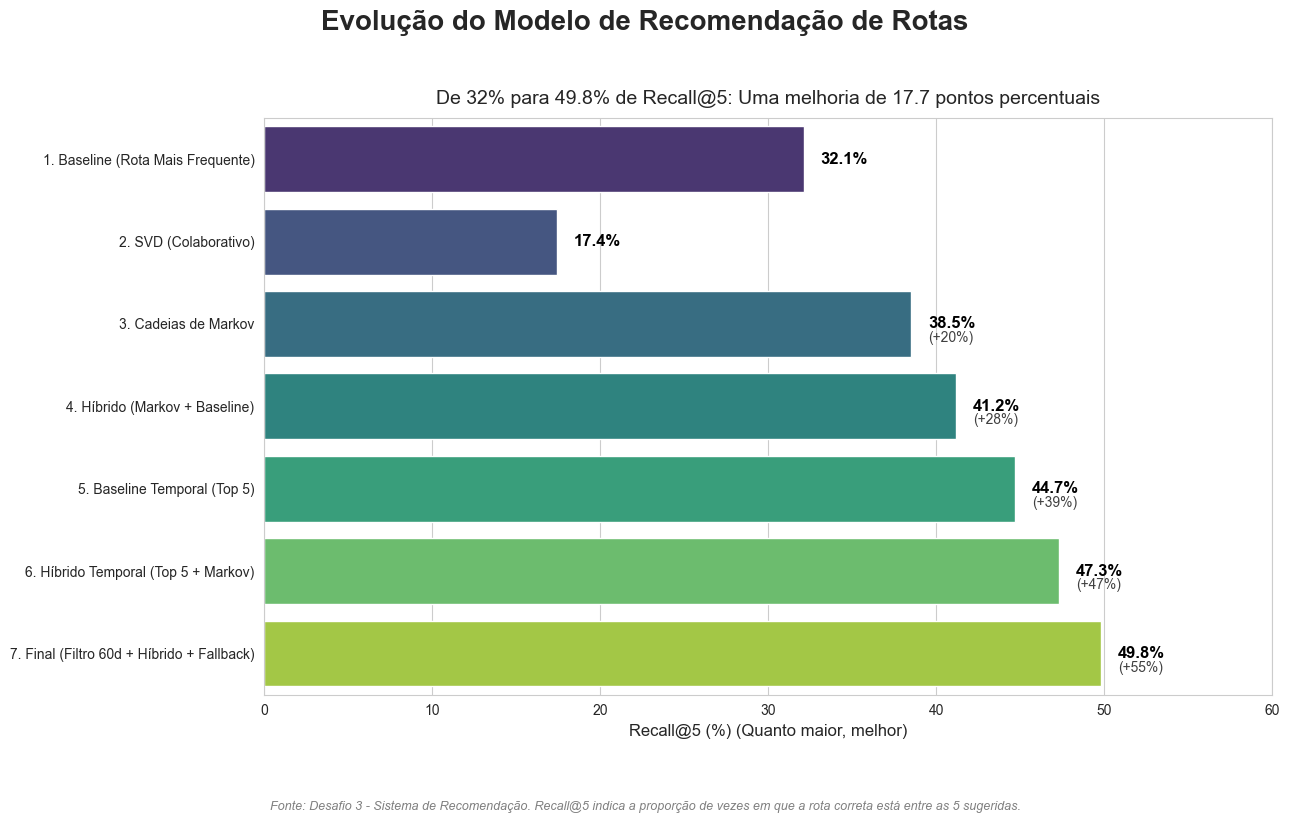

In [11]:
# Dados fictícios de evolução dos modelos do Desafio 3
data = {
    'Estratégia do Modelo': [
        '1. Baseline (Rota Mais Frequente)',
        '2. SVD (Colaborativo)',
        '3. Cadeias de Markov',
        '4. Híbrido (Markov + Baseline)',
        '5. Baseline Temporal (Top 5)',
        '6. Híbrido Temporal (Top 5 + Markov)',
        '7. Final (Filtro 60d + Híbrido + Fallback)'
    ],
    'Recall@5 (%)': [32.1, 17.4, 38.5, 41.2, 44.7, 47.3, 49.8]
}

df_evolucao = pd.DataFrame(data)

# Estilo profissional
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(figsize=(13, 8))

bars = sns.barplot(
    x='Recall@5 (%)',
    y='Estratégia do Modelo',
    data=df_evolucao,
    palette='viridis',
    ax=ax
)

# Título e subtítulo
fig.suptitle('Evolução do Modelo de Recomendação de Rotas', fontsize=20, fontweight='bold', ha='center')
ax.set_title(
    f'De 32% para {df_evolucao["Recall@5 (%)"].iloc[-1]:.1f}% de Recall@5: Uma melhoria de {(df_evolucao["Recall@5 (%)"].iloc[-1] - df_evolucao["Recall@5 (%)"].iloc[0]):.1f} pontos percentuais',
    fontsize=14, pad=10
)

ax.set_xlabel('Recall@5 (%) (Quanto maior, melhor)', fontsize=12)
ax.set_ylabel('')
ax.set_xlim(0, 60)

# Anotações de valores e melhorias
recall_inicial = df_evolucao['Recall@5 (%)'].iloc[0]
for bar in ax.patches:
    valor = bar.get_width()
    melhoria_percentual = ((valor - recall_inicial) / recall_inicial) * 100
    # Valor principal
    ax.text(
        valor + 1,
        bar.get_y() + bar.get_height() / 2,
        f'{valor:.1f}%',
        va='center',
        fontsize=12,
        fontweight='bold',
        color='black'
    )
    # Melhoria percentual (exceto para o primeiro)
    if valor > recall_inicial:
        ax.text(
            valor + 1,
            bar.get_y() + bar.get_height() / 1.4,
            f'(+{melhoria_percentual:.0f}%)',
            va='center',
            fontsize=10,
            color='#404040'
        )

# Rodapé explicativo
fig.text(
    0.5, -0.02,
    'Fonte: Desafio 3 - Sistema de Recomendação. Recall@5 indica a proporção de vezes em que a rota correta está entre as 5 sugeridas.',
    ha='center', fontsize=9, style='italic', color='gray'
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()